<a href="https://colab.research.google.com/github/rogerwzeng/BigDataSystems/blob/main/muTwoProfiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS265 Systems Project - Activation Checkpointing
### Implementing the $\mu$-Two Compiler
### Spring 2025, Harvard University

In [2]:
!pip install wandb onnx datasets -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.1 MB/s eta 0:00:00


In [3]:
import os
os.environ['PATH'] += ':/usr/local/cuda-11.0/bin'

In [4]:
from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [5]:
# -----------
# mu-Two Profiler
# -----------
import operator
import time
import pdb
import numpy as np
from typing import Any, Dict, List
from dataclasses import dataclass
import torch
from torch import nn as nn
from torch import fx as fx
from torch.cuda import Event
from torch.fx import symbolic_trace, Interpreter, Node, GraphModule
from torch.autograd import grad
from torch.profiler import profile, record_function, ProfilerActivity, DeviceType
from torch.utils.data import DataLoader
from torch.utils.checkpoint import checkpoint
from torchvision import datasets
import torchvision.models as models
from torchvision.transforms import ToTensor, Lambda, Compose
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt


In [6]:
import wandb
from google.colab import userdata
wb_api_key = userdata.get('WANDB_API_KEY')
wandb.login(key = wb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rogerwzeng (rogerwzeng-harvard-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [41]:
# ------------------------------------
# mu-Two Profiler: extended torch.fx Interpreter
# ------------------------------------

@dataclass
class NodeProfile:
    first_fwd_access: int = -1
    last_fwd_access: int = -1
    first_bwd_access: int = -1
    last_bwd_access: int = -1
    cuda_time: float = 0.0
    memory_consumed: int = 0
    swap_in_time: float = 0.0
    swap_out_time: float = 0.0

class MemoryProfiler(torch.profiler.profile):
    def __init__(self, module: nn.Module, batch_size: int, input_shape):
        super().__init__(
            activities=[ProfilerActivity.CUDA],
            record_shapes=False, profile_memory=True,
            with_stack=False)

        # Compile the module
        self.module = torch.compile(
            module,
            backend="inductor",  # inductor,
            mode="default"  # Options: 'default', 'reduce-overhead', 'max-autotune'
        )

        if not torch.cuda.is_available():
          raise RuntimeError("CUDA device required for profiling")
        self.device = 'cuda'

        self.batch_size = batch_size
        self.input_shape = input_shape
        self.node_profiles: Dict[str, NodeProfile] = {}
        self.current_step = 0
        self.is_backward = False

        # Initialize CUDA events for timing
        self.start_event = Event(enable_timing=True)
        self.end_event = Event(enable_timing=True)
        self.swap_in_start = Event(enable_timing=True)
        self.swap_in_end = Event(enable_timing=True)
        self.swap_out_start = Event(enable_timing=True)
        self.swap_out_end = Event(enable_timing=True)

        # Pinned memory buffer for efficient transfers
        self.pinned_memory = torch.empty((batch_size, 3, 224, 224),
                dtype=torch.float32, device='cpu', pin_memory=True)

    def run_node(self, node: fx.Node) -> Any:
        # Record access patterns in NodeProfile
        if node.name not in self.node_profiles:
            self.node_profiles[node.name] = NodeProfile()

        profile_data = self.node_profiles[node.name]

        if not self.is_backward:
            if profile_data.first_fwd_access == -1:
                profile_data.first_fwd_access = self.current_step
            profile_data.last_fwd_access = self.current_step
        else:
            if profile_data.first_bwd_access == -1:
                profile_data.first_bwd_access = self.current_step
            profile_data.last_bwd_access = self.current_step

        # Profile CUDA operations
        with profile(activities=activities, record_shapes=False, with_stack=False, profile_memory=True) as prof:
          with record_function(f"node_{node.name}"):
              # Measure swap-in time if needed
              self.start_event.record()
              # Use compiled graph for execution
              if hasattr(node, 'target') and callable(node.target):
                result = self.compiled_graph(node.args[0] if node.args else None)
              else:
                result = super().run_node(node)
              self.end_event.record()

              torch.cuda.synchronize()
              profile_data.cuda_time = self.start_event.elapsed_time(self.end_event)

        # Record memory stats
        if isinstance(result, torch.Tensor) and result.is_cuda:
            profile_data.memory_consumed = result.element_size() * result.nelement()

        # Logging by export for Chrome://tracing
        prof.export_chrome_trace("trace.json")
        #prof.export_memory_timeline("memory_timeline.html")

        # Logging to file
        sort_by_keyword = "self_" + self.device + "_memory_usage"
        with open("profile.log", 'a') as f:
            f.write(f"Node: {node.name} memory usage: {profile_data.memory_consumed}\n")
            f.write(prof.key_averages(group_by_input_shape=False).table(sort_by=sort_by_keyword, row_limit=5))

        # WandB logging
        wandb.log({"first_fwd_access": profile_data.first_fwd_access,
            "last_fwd_access": profile_data.last_fwd_access,
            "first_bwd_access": profile_data.first_bwd_access,
            "last_bwd_access": profile_data.last_bwd_access,
            "cuda_time": profile_data.cuda_time,
            "memory_consumed": profile_data.memory_consumed,
            "swap_in_time": profile_data.swap_in_time,
            "swap_out_time": profile_data.swap_out_time,
            #"memory_breakdown": wandb.Table(
            #columns=["node_name", "memory_allocated"],
            #data=[[node.name, result.element_size() * result.nelement()]])
            })

        return result

    def run(self, *args, **kwargs):
      self.is_backward = False

      # profiling
      with torch.no_grad():
        self.start()
        result = self.module(*args, **kwargs)
        self.stop()

      self.current_step += 1

      return result

    def run_graph_with_checkpointing(self, *args, **kwargs):
      """Run the graph with activation checkpointing enabled"""
      self.is_backward = False

      # Warmup run
      with torch.no_grad():
        # self.run(*args)
        _ = self.module(*args, **kwargs)

      # Actual profiling run
      torch.cuda.synchronize()
      torch.cuda.empty_cache()

      # call checkpoint
      def run_checkpoint(*args, **kwargs):
        self.current_step += 1
        return checkpoint(self.module, *args, **kwargs)

      # profiling
      self.start()
      result = run_checkpoint(*args, **kwargs)
      self.stop()

      return result

In [42]:
config = dict(
    input_shape = (3, 224, 224),
    batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]
)

In [43]:
# ---------------------------------------------
# mu-Two Profiler: Memory Analyzer + Plotter
# ---------------------------------------------
class MemoryAnalyzer:
  """
  Analyzes and visualizes memory consumption and latency patterns
  for PyTorch models with varying batch sizes.
  """
  def __init__(self, model: nn.Module, batch_sizes: List[int] = None, input_shape: tuple = (3, 224, 224)):
      self.model = model
      self.batch_sizes = config.get('batch_sizes', batch_sizes)
      self.input_shape = config.get('input_shape', input_shape)
      self.results: List[Tuple[int, float, float]] = []  # (batch_size, memory, latency)

  def profile_model(self, batch_size: int, use_checkpointing: bool = False, input_shape: tuple = None):
    try:
      input_shape = input_shape or (batch_size, *self.input_shape)
      sample_input = torch.randn(input_shape, device='cuda')
      fx_model = torch.compile(self.model, backend="inductor")

      # Initialize profiler
      profiler = MemoryProfiler(fx_model, batch_size, input_shape)

      # Measure peak memory and latency
      torch.cuda.reset_peak_memory_stats()
      start_time = time.time()

      # Profile with or without checkpointing
      if use_checkpointing:
          output = profiler.run_graph_with_checkpointing(sample_input)
      else:
          output = profiler.run(sample_input)

      latency = time.time() - start_time
      peak_memory = torch.cuda.max_memory_allocated()

      return peak_memory, latency

    except RuntimeError as e:
      print(f"Error during profiling: {e}")
      return 0, 0

  def run_analysis(self):
    # initiate WandB logging
    with wandb.init(project="mu-Two", config=globals().get('config', {})):
      config = wandb.config
      wandb.watch(self.model, log="all")

      # main loop to iterate through batch sizes
      for batch_size in self.batch_sizes:
        # Empty cache before each run
        torch.cuda.empty_cache()

        # Without checkpointing
        mem_no_cp, lat_no_cp = self.profile_model(batch_size, False)

        # With checkpointing
        mem_with_cp, lat_with_cp = self.profile_model(batch_size, True)

        # Log results for wandb
        wandb.log({"batch_size": batch_size,
              "mem_no_cp": mem_no_cp,
              "mem_with_cp": mem_with_cp,
              "lat_no_cp": lat_no_cp,
              "lat_with_cp": lat_with_cp})

        # log results for matplotlib
        self.results.append((batch_size, mem_no_cp, mem_with_cp,
                    lat_no_cp, lat_with_cp))

        # save topo-graph in W&B
        #torch.onnx.export(self.model, torch.randn(1, 3, 224, 224).cuda(), "resnet152.onnx")
        #wandb.save("resnet152.onnx")

  # plot epoch level results
  def plot_results(self, save_path: str = None):

    batch_sizes = [r[0] for r in self.results]
    mem_no_cp = [r[1] / 1e6 for r in self.results]  # Convert to MB
    mem_with_cp = [r[2] / 1e6 for r in self.results]
    lat_no_cp = [r[3] * 1000 for r in self.results]  # Convert to ms
    lat_with_cp = [r[4] * 1000 for r in self.results]

    # Memory consumption plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(len(batch_sizes)) - 0.2, mem_no_cp, 0.4,
            label='Without Checkpointing')
    plt.bar(np.arange(len(batch_sizes)) + 0.2, mem_with_cp, 0.4,
            label='With Checkpointing')
    plt.xlabel('Batch Size')
    plt.ylabel('Peak Memory (MB)')
    plt.xticks(range(len(batch_sizes)), batch_sizes)
    plt.legend()
    plt.title('Peak Memory Consumption vs Batch Size')

    # Latency plot
    plt.subplot(1, 2, 2)
    plt.plot(batch_sizes, lat_no_cp, 'b-o', label='Without Checkpointing')
    plt.plot(batch_sizes, lat_with_cp, 'r-o', label='With Checkpointing')
    plt.xlabel('Batch Size')
    plt.ylabel('Iteration Latency (ms)')
    plt.legend()
    plt.title('Iteration Latency vs Batch Size')

    plt.tight_layout()

    if save_path:
      plt.savefig(save_path)

    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


batch_size,▁▁▁▁▂▃▄█
lat_no_cp,▁▁▁▁▂▂▄█
lat_with_cp,▁▁▁▁▂▂▄█
mem_no_cp,▁▁▁▁▂▃▄█
mem_with_cp,▁▁▁▁▂▃▄█
batch_size,128
lat_no_cp,0.92909
lat_with_cp,1.85606
mem_no_cp,3815201792
mem_with_cp,3815713792


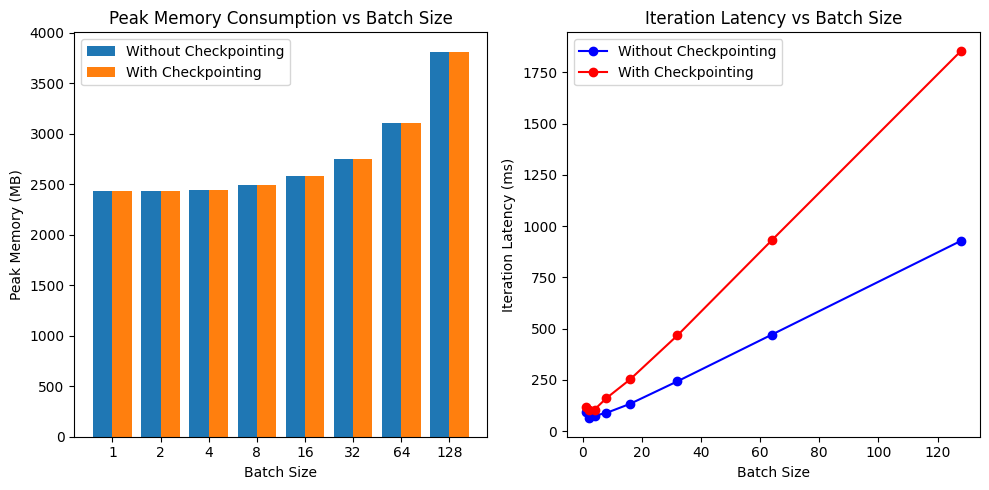

Traceback (most recent call last):
  File "<ipython-input-43-839715c30a2c>", line 55, in run_analysis
    mem_no_cp, lat_no_cp = self.profile_model(batch_size, False)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-43-839715c30a2c>", line 32, in profile_model
    output = profiler.run(sample_input)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-41-bfe952062fc9>", line 119, in run
    result = self.module(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py", line 465, in _fn
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/models/bert/modeling_bert.py", line 1064, in forward
    batch_size, seq_length = input_shape
    ^^^^^^^^^^^^^^^^^^^^^^
ValueError: too many values to unpack (expected 2)


ValueError: too many values to unpack (expected 2)

In [44]:
# -------------------------------------------------------
# Main function
# -------------------------------------------------------

def profile_resnet():
    model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1).cuda()
    analyzer = MemoryAnalyzer(model)
    analyzer.run_analysis()
    analyzer.plot_results()

def profile_bert():
    model = BertModel.from_pretrained('bert-base-uncased').cuda()
    analyzer = MemoryAnalyzer(model)
    bert_input_shape = (128,)
    analyzer.run_analysis()
    analyzer.plot_results()

if __name__ == "__main__":
  # Require GPU
  if not torch.cuda.is_available():
    raise RuntimeError("CUDA device required for profiling")

  profile_resnet()
  profile_bert()